<a href="https://colab.research.google.com/github/Cpt-Shaan/Summer_Intern_2024_IvLabs/blob/main/CIFAR10_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the Object detection model based on the CIFAR-10 dataset to classify objects into 10 different classes :-


*   plane
*   car
*   bird
*   cat
*   deer
*   dog
*   frog
*   horse
*   ship
*   truck

The model is implemented using a deep CNN architecture , along with batch-normalization and dropout layers for regularization and reduce overfitting.



Importing all the required libraries and functionalities

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets  # For the CIFAR-10 dataset
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

Transforming data to tensor and pre-processing of data by normalizing it

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),]) # Normalizing the data by setting mean and standard deviation

Downloading the dataset and separating it to train and test datasets

In [ ]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:10<00:00, 16332859.76it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Dividing data into batches of size 1024

In [ ]:
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=True, num_workers=2)

In [ ]:
# Classes to classify data into
classes = ['plane' , 'car' , 'bird' , 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' , 'truck' ]

Defining the model architecture

1. 2D Convolutional Layer with filter size 5 and 16 feature maps with 20% dropout, and Batch Normalization.
2. Max Pooling Layer of stride = 2
3. 2D Convolutional Layer with filter size 5 and 32 feature maps with 20% dropout, and Batch Normalization.
4. Max Pooling Layer of stride = 2
5. 2D Convolutional Layer with filter size 5 and 64 feature maps with 20% dropout, and Batch Normalization.
6. Max Pooling Layer of stride = 2
7. 2D Convolutional Layer with filter size 1 and 16 feature maps and Batch Normalization.
8. Dense Layer with 256 neurons
9. Dense Layer with 128 neurons
10. Dense Layer with 64 neurons
11. Dense Layer with 10 neurons (Softmax Output)

Activation Function ReLu used for all hidden layers (Convolutional and Dense) to introduce non-linearity


In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,16,5, padding=2)
    self.batchnorm1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16,32,5, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,64,5, padding=2)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(64,16,1)
    self.batchnorm4 = nn.BatchNorm2d(16)
    self.drop = nn.Dropout(0.2)
    self.fc1 = nn.Linear(16*4*4, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

# Defining the Forward Propogation steps
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(self.batchnorm1(F.relu(x)))
    x = self.drop(x)
    x = self.conv2(x)
    x = self.pool(self.batchnorm2(F.relu(x)))
    x = self.drop(x)
    x = self.conv3(x)
    x = self.pool(self.batchnorm3(F.relu(x)))
    x = self.drop(x)
    x = self.conv4(x)
    x = self.batchnorm4(F.relu(x))
    x = x.view(-1,16*4*4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Defining the Training and Test Steps and setting the optimizer (Adam's Optimizer) and Loss function as Cross Entropy Loss.

In [ ]:
# Setting the Device to GPU if available else using the CPU itself
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet().to(device)
optimizer = optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.CrossEntropyLoss() # Loss function for the model

# List for storing epoch-wise test accuracy and loss to later plot it against no of epochs
accuracy = []
loss = []

# Defining the Training step
def train(epoch):
  model.train()
  for batch_idx, (data,target) in enumerate(train_loader):
    data, target = data.to(device) , target.to(device)
    optimizer.zero_grad() # Setting the Gradients to zero initially
    output = model(data)  # Forward Propogation step
    loss = loss_fn(output, target)
    loss.backward() # Backward Propogation step
    optimizer.step()

    # Print for every 20 batches
    if batch_idx % 20 == 0:
      print(f'Train epoch {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)} ({100. * batch_idx / len(train_loader) :.0f}%)] \t {loss.item() :.4f}')

# Defining the Test Step
def test():
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device) , target.to(device)
      output = model(data)  # Only Forward Propogation Step
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim = True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  # Appending the test loss and accuracy after every epoch
  accuracy.append(100. * correct / len(test_loader.dataset))
  loss.append(test_loss)
  test_loss /= len(test_loader.dataset)
  print(f'Test Set Average Loss: {test_loss} , Accuracy: {correct} / {len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%\n)')


Training the Model and simultaneously calculating the test loss and accuracy

In [ ]:
for epoch in range(1,100):
  train(epoch)
  test()

Train epoch 1 [0 / 50000 (0%)] 	 2.3077
Train epoch 1 [20480 / 50000 (41%)] 	 1.7159
Train epoch 1 [40960 / 50000 (82%)] 	 1.4708
Test Set Average Loss: 0.0015019782066345215 , Accuracy: 4457 / 10000 (45%
)
Train epoch 2 [0 / 50000 (0%)] 	 1.3431
Train epoch 2 [20480 / 50000 (41%)] 	 1.3205
Train epoch 2 [40960 / 50000 (82%)] 	 1.2830
Test Set Average Loss: 0.001239332413673401 , Accuracy: 5601 / 10000 (56%
)
Train epoch 3 [0 / 50000 (0%)] 	 1.2180
Train epoch 3 [20480 / 50000 (41%)] 	 1.1275
Train epoch 3 [40960 / 50000 (82%)] 	 1.0652
Test Set Average Loss: 0.0010759825587272644 , Accuracy: 6155 / 10000 (62%
)
Train epoch 4 [0 / 50000 (0%)] 	 1.0976
Train epoch 4 [20480 / 50000 (41%)] 	 1.0300
Train epoch 4 [40960 / 50000 (82%)] 	 0.9808
Test Set Average Loss: 0.000983550524711609 , Accuracy: 6524 / 10000 (65%
)
Train epoch 5 [0 / 50000 (0%)] 	 1.0261
Train epoch 5 [20480 / 50000 (41%)] 	 1.0118
Train epoch 5 [40960 / 50000 (82%)] 	 0.9258
Test Set Average Loss: 0.0009196051716804504

Maximum accuracy of 78.81% obtained in 100 epochs with a learning rate of 0.001

Plotting the Test Loss and Accuracy v/s no of epochs

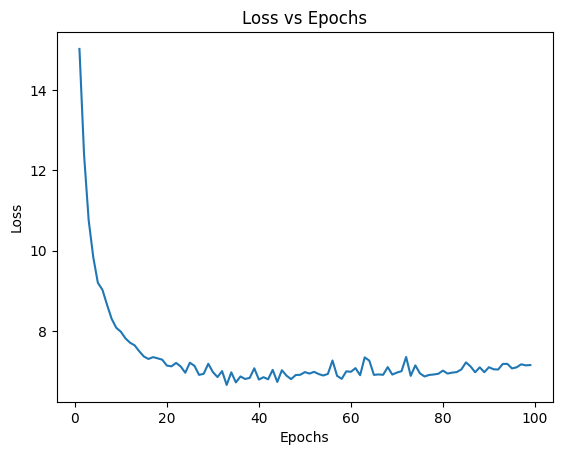

In [ ]:
epochs = np.linspace(1,99,99)

plt.plot(epochs,loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

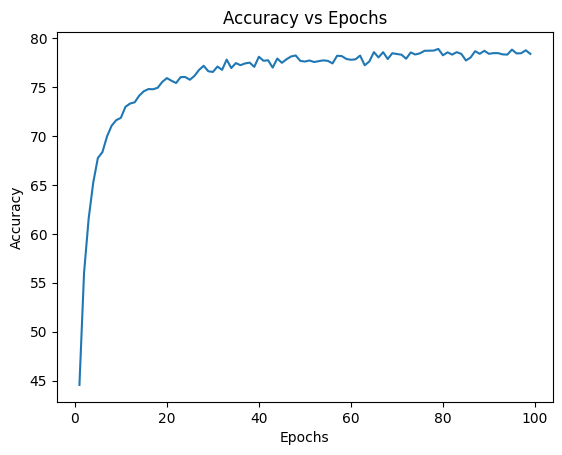

In [ ]:
plt.plot(epochs,accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()